#Importing library
Required library: OS, glob, pandas, datetime, numpy, seaborn, matplotlib, tensorflow, sklearn

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import glob
import pandas as pd
import datetime
from datetime import date,timedelta
from datetime import datetime as dt
from dateutil.relativedelta import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# TensorFlow and Keras imports.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, InputLayer, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
import sklearn


# Scikit-learn imports.
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

#Import library for calculating indicators
!pip install pandas_ta
import pandas_ta as ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=eeebf457809f45f25594d545c2d1414202089fb8868cf4ceec132bd0f9bf4071
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
#Declaring some constants
goodmse = 0.1

#Making the filepath to the dataset a global directory
path = '/content/gdrive/My Drive/data-vn-20230228/'
os.chdir(path)

#Setting up a folder for storing best models
bestModelDir = "./best_models/"
if not os.path.exists(bestModelDir):
  print("True")
  os.makedirs(bestModelDir)

#Data preprocessing

##Company filtering
Choose banks only

In [ ]:
temp = pd.read_csv("ticker-overview.csv")
temp[temp["industryEn"] == "Banks"]["ticker"]

36      ABB
41      ACB
129     BID
287     CTG
423     EIB
472     BVB
545     HDB
697     KLB
773     LPB
777     MBB
812     MSB
824     NAB
833     BAB
890     NVB
894     OCB
929     PGB
1149    SSB
1159    SGB
1174    SHB
1234    STB
1268    TCB
1357    TPB
1420    VAB
1435    VCB
1477    VIB
1564    VPB
1599    VBB
Name: ticker, dtype: object

In [ ]:
#Preparing the list of names of bank.
finName = []
for file in temp[temp["industryEn"] == "Banks"]["ticker"]:
  tempPath = "stock-historical-data/" + file +"-*"
  for i in glob.glob(tempPath.format("csv")):
    finName.append(i)

In [ ]:
#Preparing the list of names of bank.
finRatio = []
for file in temp[temp["industryEn"] == "Banks"]["ticker"]:
  tempPath = "financial-ratio/" + file +"-*"
  for i in glob.glob(tempPath.format("csv")):
    finRatio.append(i)

In [ ]:
len(finRatio)

28

In [ ]:
#combine all files in the list
ratio = pd.DataFrame()
count = 0
for file in finRatio:
 data = pd.read_csv(file)
 ratio = pd.concat([ratio, data], axis=0)
 count+=1
print(count)

28


In [ ]:
ratio = ratio[(ratio["year"]==2022) & (ratio["quarter"] == 4)]
ratio = ratio.sort_values("ticker", ignore_index=True)
# ratio.drop(["Unnamed: 0"], axis=1, inplace=True)
ratio.dropna(axis=1, inplace=True)
companyAna = ratio[["ticker", "priceToBook"]]
companyAna = companyAna[companyAna["priceToBook"]>0]
companyAna.sort_values(["priceToBook"], ascending=False, ignore_index=True, inplace=True)
# companyAna = companyAna.drop(labels = 25, axis=0)

In [ ]:
companyAna.head(10)

,ticker,priceToBook
0,VCB,3.2
1,SSB,2.5
2,BID,2.2
3,NVB,1.6
4,ACB,1.5
5,BAB,1.4
6,VIB,1.4
7,CTG,1.3
8,EIB,1.3
9,TPB,1.2


Filter the company which has more than 730 days (2 years) of stock price records

In [ ]:
#Preparing the list of names of bank.
finName = []
tickerName = []
for file in companyAna["ticker"]:
  tempPath = "stock-historical-data/" + file +"-*"
  for i in glob.glob(tempPath.format("csv")):
    temp = pd.read_csv(i, parse_dates = ["TradingDate"])
    first = pd.to_datetime(temp["TradingDate"][0], dayfirst= True)
    last = pd.to_datetime(temp["TradingDate"][len(temp)-1], dayfirst= True)
    if (last-first > timedelta(days = 365)):
      finName.append(i)
      tickerName.append(file)

In [ ]:
finName

['stock-historical-data/VCB-VNINDEX-History.csv',
 'stock-historical-data/SSB-VNINDEX-History.csv',
 'stock-historical-data/BID-VNINDEX-History.csv',
 'stock-historical-data/NVB-HNXIndex-History.csv',
 'stock-historical-data/ACB-VNINDEX-History.csv',
 'stock-historical-data/BAB-HNXIndex-History.csv',
 'stock-historical-data/VIB-VNINDEX-History.csv',
 'stock-historical-data/CTG-VNINDEX-History.csv',
 'stock-historical-data/EIB-VNINDEX-History.csv',
 'stock-historical-data/TPB-VNINDEX-History.csv',
 'stock-historical-data/STB-VNINDEX-History.csv',
 'stock-historical-data/PGB-UpcomIndex-History.csv',
 'stock-historical-data/VPB-VNINDEX-History.csv',
 'stock-historical-data/HDB-VNINDEX-History.csv',
 'stock-historical-data/MBB-VNINDEX-History.csv',
 'stock-historical-data/SGB-UpcomIndex-History.csv',
 'stock-historical-data/LPB-VNINDEX-History.csv',
 'stock-historical-data/MSB-VNINDEX-History.csv',
 'stock-historical-data/OCB-VNINDEX-History.csv',
 'stock-historical-data/KLB-UpcomIndex-His

In [ ]:
len(finName)

28

#Function define


##Window sliding
Split the data by using window sliding, with a window_size and prediction day - Using window_size data to predict (prediction day) stocks ahead

In [ ]:
def window_sliding(data, window, prediction_day):
  """Load and split data into training features and labels"""
  X_data, y_data = [], []
  for i in range(len(data) - window- prediction_day):
      X_data.append(data.iloc[i:i + window].to_numpy())
      y_data.append(data.iloc[i + window:i + window + prediction_day].to_numpy())
  return X_data, y_data

##Min max scaling normalization - denormalization
LSTM model works best with data in rage [0,1], therefore data must be normalized using min-max scaling

In [ ]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
# This works for the data after applying window sliding
def minMaxScaling(X, y):
  X_norm = X.copy()
  y_norm = y.copy()
  for i in range(0, len(X)):
      min_feature = np.min(X[i])
      max_feature = np.max(X[i])
      X_norm[i] = (X[i] - min_feature) / (max_feature - min_feature)
      y_norm[i] = (y[i] - min_feature) / (max_feature - min_feature)
  return X_norm, y_norm

In [ ]:
# This works for the data after applying window sliding
def denormMinMax(X, y):
  # MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
  X_denorm = X.copy()
  y_denorm = y.copy()
  for i in range(0, len(y)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X[i])
    max_feature = np.max(X[i])
    y_denorm[i] = y[i] * (max_feature - min_feature) + min_feature
  return X_denorm, y_denorm

In [ ]:
#This works for the data without being through window sliding
def denorm_training(y, X):
  min_feature = np.min(X)
  max_feature = np.max(X)
  return y * (max_feature - min_feature) + min_feature

In [ ]:
#This works for the data without being through window sliding
def normalize_training(X):
    min_feature = np.min(X)
    max_feature = np.max(X)
    X_norm = (X - min_feature) / (max_feature - min_feature)
    return X_norm

##Model creation using LSTM model

In [ ]:
### Create and train the model

def modelLSTM(X_train_norm, y_train_norm, X_test_norm, y_test_norm, feature, pDay):
  ### Create the model
  model = keras.Sequential()
  model.add(keras.layers.Input(shape=(X_train_norm.shape[1:])))
  model.add(keras.layers.LSTM(units=128, return_sequences=True))
  model.add(Dropout(0.5))
  model.add(keras.layers.Dense((feature))) #Number of columns in original datas used for training
  model.add(keras.layers.Cropping1D(cropping=(X_train_norm.shape[1] - pDay, 0))) #Getting the output shape as (None, prediction_day, feature)
  model.summary()

  #Training the model with callbacks for saving the best models, learning_rate reduction, and early stopping
  from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
  mc = ModelCheckpoint(filepath="epoch-{epoch:02d}.hdf5", # Path to save the model
                                        monitor='val_mse', # Metric to evaluate the model performance when looking for a better model.
                                        mode='min', # mode='auto'/'max'/'min': the monitor should be max/min to be better.
                                                    # In auto mode, the mode is set to max if the quantities monitored are 'acc' or start with 'fmeasure' (f-score) and are set to min for the rest of the quantities.
                                        verbose=0, # Inform every time a better model is found and saved.
                                        save_best_only=True) # Only save the model if the current training epoch is the best. 'False' means save models of all training epochs
  r_reduced = ReduceLROnPlateau(monitor='val_mse', mode='min', verbose = 0,
                                  factor = 0.2, patience = 5, min_lr = 0.000001)
  es = EarlyStopping(monitor='val_mse', mode='min', verbose=1, patience=10)
  model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.0001), loss='mse', metrics=['mse'], run_eagerly=True)
  model.fit(X_train_norm, y_train_norm, validation_data=(X_test_norm, y_test_norm), epochs=10,
            batch_size=4096, callbacks = [mc, r_reduced, es], verbose=1)
  # model.summary()
  return model


##Class for cross-validation
This class works similarly to the function TimeSeriessplit(), except that it allows you to specify how much data for each training and validation set you want

In [ ]:
'''
Parameters
----------
train_period: int
    number of days to include in the training set
test_period: int
    number of days to include in the validation set
    default is 7
freq: string
    This parameter is useful when we pass the data with a column corresponding to the time of records. However, our data during the training process do not include the TradingDate column,
    hence this parameter remains unused
'''
class TimeSeriesCV(object):


    def __init__(self, train_period, test_period, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq


    '''
    Generate indices to split data into training and validation set

    Parameters
    ----------
    data: Original data.
    gap: int, default=0
        In case one wants to have a gap between training set and validation set

    Returns
    -------
    listTrain, listTest:
        list of tuples (train index, test index) similar to sklearn model selection
    '''
    def split(self, data, gap=0):

        listTrain = []
        listTest = []

        start_train = 0
        end_train = start_train + self.train_period
        start_test = end_train + gap
        end_test = start_test + self.test_period

        while end_test < data.shape[0]:
            # train indices:
            trainIndex = []
            testIndex = []
            for i in range(start_train, end_train):
              trainIndex.append(i)
            for i in range (start_test, end_test):
              testIndex.append(i)

            print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(trainIndex), ", # test records", len(testIndex))

            listTrain.append(trainIndex)
            listTest.append(testIndex)

            # update dates:
            start_train = start_train
            end_train += self.train_period
            start_test = end_train + gap
            end_test = start_test + self.test_period

        # In case the end_test > data.shape[0], but there are still some remaining dates. In this case, the codes below cover the remaining index
        end_test = data.shape[0]
        start_test = end_test - self.test_period
        end_train = start_test
        trainIndex = []
        testIndex = []
        for i in range(start_train, end_train):
          trainIndex.append(i)
        for i in range (start_test, end_test):
          testIndex.append(i)
        listTrain.append(trainIndex)
        listTest.append(testIndex)
        print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(trainIndex), ", # test records", len(testIndex))

        index_output = [(train,test) for train,test in zip(listTrain, listTest)]
        self.n_splits = len(index_output)

        return index_output


    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits

#Model training

##Training the models using cross-validation technique to choose the best models

In [ ]:
#Choose the features for the models
columns = ["Open", "High", "Low", "Close"]
#Choose the window_size and prediction day
window_size = 90
prediction_day = 7
#Array to save the best companies with best models
goodCom = []
goodComPath = []
allMse = []
#Cross-validation for each company to pick the best ones with the best models
for name in finName:
  #Pre-processing the data
  data_for_modeling=pd.read_csv(name)[columns]
  X_data, y_data = window_sliding(data_for_modeling, window_size, prediction_day)
  X_data, y_data = np.array(X_data), np.array(y_data)
  X_train, X_test, y_train, y_test= train_test_split(X_data, y_data, test_size=0.2, shuffle=False, random_state=0)
  # y_train, y_test= train_test_split(y_data, test_size=0.2, shuffle=False, random_state=0)
  X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
  X_test_norm, y_test_norm = minMaxScaling(X_test, y_test)
  print(X_train.shape, y_train.shape)
  print("Shape of test set: ", X_test.shape, y_test.shape)
  #Array to save the models and mse values
  ensemble = []
  mses = []
  #Create TimeBasedCV object with specifeid train and test periods. Frequency = 'day', although the parameters is useless for this case
  tscv = TimeSeriesCV(train_period=365,
                    test_period=180,
                    freq='days')
  #Cross-validation for the folds by TimeSeriesCV object
  for train_index, test_index in tscv.split(X_train):
    #Picking up the data
      X_train_VC   = X_train[train_index]
      y_train_VC = y_train[train_index]

      X_val_VC    = X_train[test_index]
      y_val_VC  = y_train[test_index]

      #Normalize the data features and labels
      X_train_norm, y_train_norm = minMaxScaling(X_train_VC, y_train_VC)
      X_val_norm, y_val_norm = minMaxScaling(X_val_VC, y_val_VC)

      #Call the model to train on the data
      model1 = modelLSTM(X_train_norm, y_train_norm, X_val_norm, y_val_norm, len(columns), prediction_day)
      #Append the model for later evaluation
      ensemble.append(model1)
      loss, mse = model1.evaluate(X_test_norm, y_test_norm, verbose=0)
      mses.append(mse)

  overall_mse = np.average(mses)
  allMse.append(overall_mse)
  print("Overall MSE: ", overall_mse)
# Pick the models with mse lower than the threshold
  if overall_mse < goodmse:
     goodCom.append(tickerName[finName.index(name)])
     goodComPath.append(name)
     ensemble[np.argmin(mses)].save(filepath=bestModelDir + tickerName[finName.index(name)], include_optimizer=False)
     data_for_modeling["ticker"] = tickerName[finName.index(name)]

(2652, 90, 4) (2652, 7, 4)
Shape of test set:  (664, 90, 4) (664, 7, 4)
Train period: 0 - 365 , Test period 365 - 545 # train records 365 , # test records 180
Train period: 0 - 730 , Test period 730 - 910 # train records 730 , # test records 180
Train period: 0 - 1095 , Test period 1095 - 1275 # train records 1095 , # test records 180
Train period: 0 - 1460 , Test period 1460 - 1640 # train records 1460 , # test records 180
Train period: 0 - 1825 , Test period 1825 - 2005 # train records 1825 , # test records 180
Train period: 0 - 2190 , Test period 2190 - 2370 # train records 2190 , # test records 180
Train period: 0 - 2472 , Test period 2472 - 2652 # train records 2472 , # test records 180
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 128)           68096     
                                                                 
 dropout (Dropo

1/1 [==============================] - 6s 6s/step - loss: 0.1911 - mse: 0.1911 - val_loss: 0.2101 - val_mse: 0.2101 - lr: 1.0000e-04
Epoch 2/10
1/1 [==============================] - 0s 329ms/step - loss: 0.1878 - mse: 0.1878 - val_loss: 0.2054 - val_mse: 0.2054 - lr: 1.0000e-04
Epoch 3/10
1/1 [==============================] - 0s 335ms/step - loss: 0.1828 - mse: 0.1828 - val_loss: 0.2007 - val_mse: 0.2007 - lr: 1.0000e-04
Epoch 4/10
1/1 [==============================] - 0s 342ms/step - loss: 0.1813 - mse: 0.1813 - val_loss: 0.1962 - val_mse: 0.1962 - lr: 1.0000e-04
Epoch 5/10
1/1 [==============================] - 0s 388ms/step - loss: 0.1767 - mse: 0.1767 - val_loss: 0.1916 - val_mse: 0.1916 - lr: 1.0000e-04
Epoch 6/10
1/1 [==============================] - 0s 316ms/step - loss: 0.1720 - mse: 0.1720 - val_loss: 0.1871 - val_mse: 0.1871 - lr: 1.0000e-04
Epoch 7/10
1/1 [==============================] - 0s 331ms/step - loss: 0.1696 - mse: 0.1696 - val_loss: 0.1827 - val_mse: 0.1827 - 

1/1 [==============================] - 1s 818ms/step - loss: 0.2493 - mse: 0.2493 - val_loss: 0.4617 - val_mse: 0.4617 - lr: 1.0000e-04
Epoch 2/10
1/1 [==============================] - 0s 149ms/step - loss: 0.2412 - mse: 0.2412 - val_loss: 0.4502 - val_mse: 0.4502 - lr: 1.0000e-04
Epoch 3/10
1/1 [==============================] - 0s 129ms/step - loss: 0.2374 - mse: 0.2374 - val_loss: 0.4390 - val_mse: 0.4390 - lr: 1.0000e-04
Epoch 4/10
1/1 [==============================] - 0s 129ms/step - loss: 0.2308 - mse: 0.2308 - val_loss: 0.4279 - val_mse: 0.4279 - lr: 1.0000e-04
Epoch 5/10
1/1 [==============================] - 0s 142ms/step - loss: 0.2247 - mse: 0.2247 - val_loss: 0.4170 - val_mse: 0.4170 - lr: 1.0000e-04
Epoch 6/10
1/1 [==============================] - 0s 137ms/step - loss: 0.2181 - mse: 0.2181 - val_loss: 0.4063 - val_mse: 0.4063 - lr: 1.0000e-04
Epoch 7/10
1/1 [==============================] - 0s 129ms/step - loss: 0.2124 - mse: 0.2124 - val_loss: 0.3958 - val_mse: 0.3958

(1143, 90, 4) (1143, 7, 4)
Shape of test set:  (286, 90, 4) (286, 7, 4)
Train period: 0 - 365 , Test period 365 - 545 # train records 365 , # test records 180
Train period: 0 - 730 , Test period 730 - 910 # train records 730 , # test records 180
Train period: 0 - 963 , Test period 963 - 1143 # train records 963 , # test records 180
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 90, 128)           68096     
                                                                 
 dropout_32 (Dropout)        (None, 90, 128)           0         
                                                                 
 dense_32 (Dense)            (None, 90, 4)             516       
                                                                 
 cropping1d_32 (Cropping1D)  (None, 7, 4)              0         
                                                 

(3240, 90, 4) (3240, 7, 4)
Shape of test set:  (810, 90, 4) (810, 7, 4)
Train period: 0 - 365 , Test period 365 - 545 # train records 365 , # test records 180
Train period: 0 - 730 , Test period 730 - 910 # train records 730 , # test records 180
Train period: 0 - 1095 , Test period 1095 - 1275 # train records 1095 , # test records 180
Train period: 0 - 1460 , Test period 1460 - 1640 # train records 1460 , # test records 180
Train period: 0 - 1825 , Test period 1825 - 2005 # train records 1825 , # test records 180
Train period: 0 - 2190 , Test period 2190 - 2370 # train records 2190 , # test records 180
Train period: 0 - 2555 , Test period 2555 - 2735 # train records 2555 , # test records 180
Train period: 0 - 2920 , Test period 2920 - 3100 # train records 2920 , # test records 180
Train period: 0 - 3060 , Test period 3060 - 3240 # train records 3060 , # test records 180
Model: "sequential_51"
_________________________________________________________________
 Layer (type)               

(1028, 90, 4) (1028, 7, 4)
Shape of test set:  (258, 90, 4) (258, 7, 4)
Train period: 0 - 365 , Test period 365 - 545 # train records 365 , # test records 180
Train period: 0 - 730 , Test period 730 - 910 # train records 730 , # test records 180
Train period: 0 - 848 , Test period 848 - 1028 # train records 848 , # test records 180
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 90, 128)           68096     
                                                                 
 dropout_61 (Dropout)        (None, 90, 128)           0         
                                                                 
 dense_61 (Dense)            (None, 90, 4)             516       
                                                                 
 cropping1d_61 (Cropping1D)  (None, 7, 4)              0         
                                                 

(993, 90, 4) (993, 7, 4)
Shape of test set:  (249, 90, 4) (249, 7, 4)
Train period: 0 - 365 , Test period 365 - 545 # train records 365 , # test records 180
Train period: 0 - 730 , Test period 730 - 910 # train records 730 , # test records 180
Train period: 0 - 813 , Test period 813 - 993 # train records 813 , # test records 180
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 90, 128)           68096     
                                                                 
 dropout_74 (Dropout)        (None, 90, 128)           0         
                                                                 
 dense_74 (Dense)            (None, 90, 4)             516       
                                                                 
 cropping1d_74 (Cropping1D)  (None, 7, 4)              0         
                                                    

In [ ]:
#Getting all mses during the cross-validation
for i in range(0, len(finName)):
  print("Company", tickerName[i])
  print("Overall mse", allMse[i])

Company VCB
Overall mse 0.32936919586999075
Company SSB
Overall mse 0.5039544701576233
Company BID
Overall mse 0.29909762740135193
Company NVB
Overall mse 0.3899608254432678
Company ACB
Overall mse 0.36142922937870026
Company BAB
Overall mse 0.056449200958013535
Company VIB
Overall mse 0.21154641608397165
Company CTG
Overall mse 0.4286357079233442
Company EIB
Overall mse 0.31254578488213675
Company TPB
Overall mse 0.08859016373753548
Company STB
Overall mse 0.35236350033018327
Company PGB
Overall mse 0.07238640636205673
Company VPB
Overall mse 0.17155749599138895
Company HDB
Overall mse 0.1250783031185468
Company MBB
Overall mse 0.33987103402614594
Company SGB
Overall mse 0.09256263077259064
Company LPB
Overall mse 0.20842940111955008
Company MSB
Overall mse 0.2914784252643585
Company OCB
Overall mse 0.4119245707988739
Company KLB
Overall mse 0.1865087995926539
Company TCB
Overall mse 0.103615902364254
Company KLB
Overall mse 0.21538452307383218
Company VBB
Overall mse 0.14431899040937

In [ ]:
#Getting the filtered company
goodCom

['BAB', 'TPB', 'PGB', 'SGB']

In [ ]:
def good_companies(goodCom):
    """Load model from the best company with its model
    Input: path to saved filtered companies csv
    Output: List of models associated with each company
    """
    filtered_companies_model = []
    for company in goodCom:
        filtered_companies_model.append(keras.models.load_model(filepath=bestModelDir + company))
    return filtered_companies_model

In [ ]:
filtered_companies_model = good_companies(goodCom)

In [ ]:
filtered_companies_model
filter_compiled_model = []
#Compile the save models
for i in filtered_companies_model:
  i.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mse'], run_eagerly=True)
  filter_compiled_model.append(i)

In [ ]:
def dfindicators(df):
    """Get the stock indicators used later in task 3 and task 4 , using pandas_ta. The indicators here are STI and RSI - supertrend and Relative strength index"""
    indicators = {"sti": ta.supertrend(df['High'], df['Low'], df['Close'], length=3, multiplier=3),
                  "rsi": ta.rsi(df["Close"], length=3)}
    return indicators

In [ ]:
def predict_one_company(company, companyPath, model):
    """Function to predict one company"""
    X = pd.read_csv(companyPath).iloc[-(window_size+prediction_day):-prediction_day][columns]
    X_norm= normalize_training(X)
    y_pred_norm = model.predict(X_norm.to_numpy()[None, ...], batch_size=1, verbose=0)
    y_pred = np.squeeze(denorm_training(y_pred_norm, X_data))
    X = pd.concat([X, pd.DataFrame(y_pred, columns=X.columns)], ignore_index=True).iloc[-(window_size+prediction_day):]
    indicators = dfindicators(X)
    return company, X, indicators

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


TPB
Price prediction for latest  7  days :


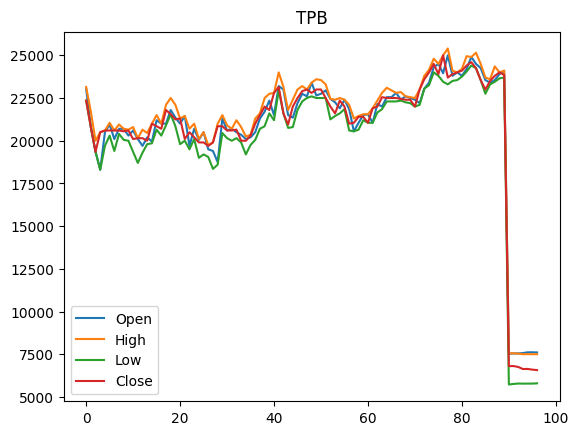

In [ ]:
# Predict one company
prediction = predict_one_company(goodCom[1], goodComPath[1], filter_compiled_model[1])
print(prediction[0])
print("Price prediction for latest ", prediction_day, " days :")
prediction[1].plot(title=prediction[0])
plt.show()



In [ ]:
def predict_companies(company, companyPath, filtered_companies_model):
    """ Function to predict all good companies. Calling predict_one_company.
    Return: A list of predicted prices from different company."""
    predictions = []
    for i in range(0, len(company)):
        predictions.append(predict_one_company(company[i], companyPath[i], filtered_companies_model[i]))
    return predictions

#Task 3: When to buy/hold/sell

In [ ]:
def decision_making(predictions):
    """Output the list of companies to keep and to sell"""
    portfolio = []
    for company in predictions:
        company_name = company[0]
        company_indicators = company[2]
        company_rsi = company_indicators["rsi"]
        company_rsi = company_rsi.iloc[-prediction_day:]
        # buy = np.argmin(company_rsi_interested)
        # sell = np.argmax(company_rsi_interested)
        # buy = buy if company_rsi_interested.iloc[buy] < 30 else None
        # sell = sell if company_rsi_interested.iloc[sell] > 70 else None
        buy = []
        sell = []
        hold = []
        index=1
        for i in company_rsi:
          if i<10:
            buy.append(index)
          elif i>80:
            sell.append(index)
          else:
            hold.append(index)
          index+=1
        if len(buy)==0:
          buy=None
        if len(sell)==0:
          sell=None
        if len(hold)==0:
          hold=None
        portfolio.append([company_name, buy, hold, sell])
    return portfolio

In [ ]:
# Predict all company & indicators
predictions = predict_companies(goodCom, goodComPath, filter_compiled_model)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: 

In [ ]:
# Portfolio management
portfolio = decision_making(predictions)
print("Company name", "Buy date", "Hold date", "Sell date")
for company in portfolio:
    print(company)

Company name Buy date Hold date Sell date
['BAB', [1, 2, 3, 4, 5, 6, 7], None, None]
['TPB', [1, 2, 3, 4, 5, 6, 7], None, None]
['PGB', [1, 2, 3, 4, 5, 6, 7], None, None]
['SGB', [1, 2, 3, 4, 5, 6], [7], None]


#Task 4: Which companies to hold

In [ ]:
!pip install git+https://github.com/thinh-vu/vnstock.git@main


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/thinh-vu/vnstock.git (to revision main) to /tmp/pip-req-build-8jeznup4
  Running command git clone --filter=blob:none --quiet https://github.com/thinh-vu/vnstock.git /tmp/pip-req-build-8jeznup4
  Resolved https://github.com/thinh-vu/vnstock.git to commit f09b4ee9c64649be5e5d78806fb419fefe99854e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for vnstock: filename=vnstock-0.1.2-py3-none-any.whl size=17826 sha256=1d70e2bafeb58eed60e409b9b23e6b4ab54f35c70df69318929b5f49f5aa003a
  Stored in directory: /tmp/pip-ephem-wheel-cache-6u_nf7bv/wheels/af/d1/dd/4a6968f5e0bb65a0f13b9340b9c6d9e185115f3514f05240ca
Successfully built vnstock


In [ ]:
from vnstock import *

In [ ]:
stock_analysis = pd.DataFrame()
for i in goodCom:
  temp = general_rating(i)
  stock_analysis = pd.concat([temp, stock_analysis])

In [ ]:
stock_analysis

,stockRating,valuation,financialHealth,businessModel,businessOperation,rsRating,taScore,ticker,highestPrice,lowestPrice,priceChange3m,priceChange1y,beta,alpha
0,3.3,2.0,2.8,3.2,2.3,1.8,1.0,SGB,14349.0,11828.0,0.046,-0.080,0.23,0.0000
0,3.4,1.8,2.8,3.0,2.5,3.4,2.0,PGB,33922.0,13508.0,0.648,0.173,1.22,0.0000
0,4.3,2.9,4.0,3.3,4.5,3.2,1.5,TPB,29739.6,17438.2,0.129,-0.170,1.01,-0.0009
0,3.7,3.2,4.1,3.0,1.8,1.7,1.0,BAB,17777.3,12400.0,-0.029,-0.223,0.79,-0.0006


In [ ]:
#Calculating the number of uptrends and downtrends each company have. If more downtrends, the company is not good for investment and vice versa
uptrend = []
downtrend = []
for company in predictions:
  interestRange = company[1].iloc[-prediction_day:]
  numUp=0
  numDown=0
  prevPivot = (interestRange["Open"].iloc[0]+interestRange["High"].iloc[0]+interestRange["Low"].iloc[0]+interestRange["Close"].iloc[0])/4
  for i in range(1, len(interestRange)):
    pivot = (interestRange["Open"].iloc[i]+interestRange["High"].iloc[i]+interestRange["Low"].iloc[i]+interestRange["Close"].iloc[i])/4
    if pivot<prevPivot:
      numDown +=1
    else:
      numUp+=1
  if numDown>numUp:
    downtrend.append(company[0])
  else:
    uptrend.append(company[0])


In [ ]:
#Sorting the stock rating and business operation rating by TCBS. Sort it in descending orders, and pick up the best company.
stock_analysis.sort_values(["stockRating", "businessOperation"], ascending=False, ignore_index=True, inplace=True)
focused_stock_analysis = stock_analysis[["ticker", "stockRating", "businessOperation"]]
focused_stock_analysis.head()

,ticker,stockRating,businessOperation
0,TPB,4.3,4.5
1,BAB,3.7,1.8
2,PGB,3.4,2.5
3,SGB,3.3,2.3


In [ ]:
print(downtrend)
print(uptrend)

['BAB', 'TPB', 'PGB', 'SGB']
[]


In [ ]:
goodCompany = []
badCompany = []
for i in focused_stock_analysis.head(5)["ticker"]:
  if not (i in downtrend):
    goodCompany.append(i)
  else:
    badCompany.append(i)
print("Good companies which have good stock ratings, business operation ratings, and more uptrends", goodCompany)
print("Bad companies with low stock ratings, business operation ratings, and more downtrends", badCompany)

Good companies which have good stock ratings, business operation ratings, and more uptrends []
Bad companies with low stock ratings, business operation ratings, and more downtrends ['TPB', 'BAB', 'PGB', 'SGB']
